# 权重初始化 正则化 梯度检查

本notebook将会完成本周的三个作业



-------

-------

-------



## 1 权重初始化

- 本notebook代码使用 `Neural Networks and Deep Learning/Week 4/Building your Deep Neural Network - Step by Step\【第四周作业合并在一起】一步一步构建深层神经网络 & 构建深度神经网络应用`编写的基础模块来实现功能,而不使用官方notebook的基础模块

- 将尝试三种方法,并观察效果
    - 0
    - random
    - he 方法 $\frac{2}{\sqrt{n}}$

### 1 package & module (可复用)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets

%matplotlib inline
plt.rcParams['figure.figsize']=(7,4)
plt.rcParams['image.interpolation']='neareast'
plt.rcParams['image.cmap']='gray'



## 定义基本函数模块

In [3]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """        
    A=1/(1+np.exp(-Z))
    cache=Z
    return A,cache
def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """    
    A=np.maximum(0,Z)
    assert(A.shape==Z.shape)
    cache=A
    return A,cache


def sigmoid_backward(dA,cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """    
    Z=cache
    s=1/(1+np.exp(-Z))
    dZ=dA*s*(1-s)
    assert (dZ.shape==Z.shape)
    return dZ

def relu_backward(dA,cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """    
    Z=cache
    dZ=np.array(dA,copy=True)
    dZ[Z<=0]=0
    assert(dZ.shape==Z.shape)
    return dZ


# linaer
def linear_forward(A,W,b):
    """
    linear forward
    

    Parameters
    ----------
    A : 上一层的activation
    W : 权重
    b : bias
    
    Returns
    -------
    Z : pre-activation
    cache : tuple of  A,W,b
        
    """    
    Z=np.matmul(W,A)+b
    assert (Z.shape==(W.shape[0],A.shape[1]))
    cache=(A,W,b)
    return Z,cache


# linear activation
def linear_activation_forward(A_prev,W,b,activation):
    """
    线性激活单元
    
    Parameters
    ----------
    A_prev :上一层激活值
    W : 权重值
    b : bias
    activation: sigmoid or relu

    Returns
    -------
    A : 激活值
    cache: linear_cache,activation_cache            
    """    
    
    if activation=='relu':    
        Z, linear_cache = linear_forward(A_prev, W, b)
        A,activation_cache=relu(Z)
    elif activation=='sigmoid':
        Z, linear_cache = linear_forward(A_prev, W, b)
        A,activation_cache=sigmoid(Z)        
        
    assert (A.shape==(W.shape[0],A_prev.shape[1]))
    cache=(linear_cache,activation_cache)
    return A,cache
    
    

# L层forward模型 L-1层sigmoid 1层relu
def L_model_forward(X,parameters):
    """
    正向传播(L-1线性+Relu，L 线性+Sigmoid)
    

    Parameters
    ----------
    X : 输入
    parameters : 参数 W b L层

    Returns
    -------
    AL : L层激活值
    caches : 每一层的cache(linear+activation)
            
    """
    L=len(parameters)//2
    A_prev=X.copy()
    caches=[]
    for l in range(1,L):
        W=parameters['W{}'.format(l)]
        b=parameters['b{}'.format(l)]
        A_prev,cache=linear_activation_forward(A_prev, W, b, activation = "relu")
        caches.append(cache)
    WL=parameters['W{}'.format(L)]
    bL=parameters['b{}'.format(L)] 
    AL,cache=linear_activation_forward(A_prev, WL, bL, activation = "sigmoid")
    caches.append(cache)
    assert(AL.shape==(1,X.shape[1]))
    return AL,caches
    
        
        
def compute_cost(AL,Y):
    """
    计算损失函数
    
    Parameters
    ----------
    AL:  
    Y : 

    Returns
    -------
    cost :         
    """
    m=Y.shape[1]
    cost=-(np.dot(np.log(AL.ravel()),Y.ravel())+np.dot((np.log(1-AL.ravel())),1-Y.ravel()))/m
    
    # dim check
    assert( isinstance(cost,float))
    
    return cost

def linear_backward(dZ,cache):
    """
    线性反向传播
    

    Parameters
    ----------
    dZ : 
    cache : linear cache A,W,b

    Returns
    -------
    dW :
    db :
    dA_prev : 
    """
    A_prev,W,b=cache
    m=A_prev.shape[1]
    
    dW=np.matmul(dZ,A_prev.T)/m
    db=np.sum(dZ,axis=1,keepdims=True)/m
    dA_prev=np.matmul(W.T,dZ)

    assert(dW.shape==(W.shape))
    assert(db.shape==(b.shape))
    assert(dA_prev.shape==A_prev.shape )   
    
    return dA_prev,dW,db
    
    
def linear_activation_backward(dA,cache,activation):
    """
    反向传播
    

    Parameters
    ----------
    dA :
    cache: activation_cache,linear_cache
    activation: relu sigmoid

    Returns
    -------
    dW :
    db :
    dA_prev : 
        
    """
    linear_cache,activation_cache=cache
    if activation=='relu':
        dZ=relu_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    elif activation=='sigmoid':
        dZ=sigmoid_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)        
    return dA_prev, dW, db    

def L_model_backward(AL,Y,caches):
    """
    backward propagation

    Parameters
    ----------
    AL : L层激活值
    Y : 
    caches : 每一层的cache(linear+activation)

    Returns
    -------
    grads: dA dW db 
    """
    L=len(caches)
    grads={}
        
    dAL=-np.divide(Y,AL)+np.divide(1-Y,1-AL)
    grads["dA{}".format(L)]=dAL
    current_cache=caches[-1]    
    grads["dA{}".format(L-1)], grads['dW{}'.format(L)],grads['db{}'.format(L)]=linear_activation_backward(dAL, current_cache, activation = "sigmoid")

    for l in reversed(range(1,L)):          
        current_cache=caches[l-1]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA{}".format(l)], current_cache, activation = "relu")    
        grads["dA{}".format(l-1)]=dA_prev_temp        
        grads['dW{}'.format(l)]=dW_temp
        grads['db{}'.format(l)]=db_temp           
    return grads
    

def update_parameters(parameters,grads,learning_rate):
    """
    参数更新
    

    Parameters
    ----------
    parameters : 所有参数 
        W1~WL : 权重 (layer_dims[1],layer_dims[1-1])
        b1~bL : bias (layer_dims[1],1) 
    grads: dA dW db 

    Returns
    -------
    parameters : 所有参数 
        W1~WL : 权重 (layer_dims[1],layer_dims[1-1])
        b1~bL : bias (layer_dims[1],1) 

    """    
    L=len(parameters)//2
    for l in range(1,L+1):
        W_temp,b_temp=parameters['W{}'.format(l)],parameters['b{}'.format(l)]        
        dW_temp,db_temp=grads['dW{}'.format(l)],grads['db{}'.format(l)]        
        parameters['W{}'.format(l)],parameters['b{}'.format(l)]=W_temp-learning_rate*dW_temp,b_temp-learning_rate*db_temp
    return parameters    

def predict(X,y,parameters):
    """
    预测
    
    Parameters
    ----------
    X : 
    y : 
    parameters: 模型参数

    Returns
    -------
    y_hat : 预测值            
    """
    m=y.shape[1]
    AL,caches=L_model_forward(X,parameters)
    y_hat=(AL>0.5)
    print("accuracy={:,.2%}".format(np.sum(y_hat==y)/m))
    
    return y_hat

def predict_dec(X,parameters):
    """
    预测
    
    Parameters
    ----------
    X : 
    y : 
    parameters: 模型参数

    Returns
    -------
    y_hat : 预测值            
    """
    AL,caches=L_model_forward(X,parameters)
    y_hat=(AL>0.5)
    
    return y_hat
    

### 2 dataset


In [4]:
def load_dataset():
    np.random.seed(1)
    train_x,train_y=sklearn.datasets.make_circles(n_samples=300,noise=0.05)
    np.random.seed(2)
    test_x,test_y=sklearn.datasets.make_circles(n_samples=100,noise=0.05)

    train_x=train_x.T
    test_x=test_x.T
    train_y=train_y.reshape(1,-1)
    test_y=test_y.reshape(1,-1)

    plt.scatter(x=train_x[0],y=train_x[1],c=np.squeeze(train_y),cmap=plt.cm.Spectral)
    return train_x,train_y,test_x,test_y

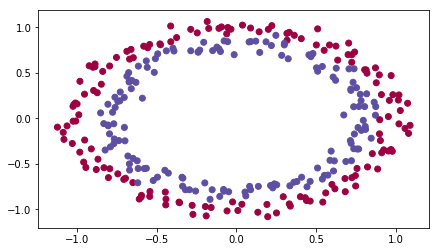

In [5]:
train_x,train_y,test_x,test_y=load_dataset()

### 3  构造不同的初始化方法并构建模型

- 注意点：（1）要设置random seed（2）he随机化方法是 乘以$\frac{2}{\sqrt{n}}$ 而不是除以$\frac{2}{\sqrt{n}}$


In [38]:
def initialize_with_layers(layers_dims,initialization='he'):
    """
    Parameters
    ----------
    layers_dims : 从输入层到输出层的各层神经元个数
    method: zero, random,he

    Returns
    -------
    parameters : 
            
    """

    
    L=len(layers_dims)-1
    parameters={}
    if initialization=='zero':
        for l in range(1,L+1):
            parameters['W{}'.format(l)]=np.zeros((layers_dims[l],layers_dims[l-1]))
            parameters['b{}'.format(l)]=np.zeros((layers_dims[l],1))
        return parameters
                
    elif initialization=='random':
        np.random.seed(3)        
        for l in range(1,L+1):
            parameters['W{}'.format(l)]=np.random.randn(layers_dims[l],layers_dims[l-1])*10
            parameters['b{}'.format(l)]=np.zeros((layers_dims[l],1))
        return parameters
        
    elif  initialization=='he':
        np.random.seed(3)          
        for l in range(1,L+1):
            parameters['W{}'.format(l)]=np.random.randn(layers_dims[l],layers_dims[l-1])*np.sqrt(2.0/layers_dims[l-1])
            parameters['b{}'.format(l)]=np.zeros((layers_dims[l],1))
        return parameters        


In [39]:
print("初始化为0")
parameters=initialize_with_layers([3,2,1],initialization='zero')
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

print("随机初始化")
parameters=initialize_with_layers([3,2,1],initialization='random')
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

print("按照he方法随机初始化")
parameters=initialize_with_layers([2,4,1],initialization='he')
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))


初始化为0
W1 = [[0. 0. 0.]
 [0. 0. 0.]]
b1 = [[0.]
 [0.]]
W2 = [[0. 0.]]
b2 = [[0.]]
随机初始化
W1 = [[ 17.88628473   4.36509851   0.96497468]
 [-18.63492703  -2.77388203  -3.54758979]]
b1 = [[0.]
 [0.]]
W2 = [[-0.82741481 -6.27000677]]
b2 = [[0.]]
按照he方法随机初始化
W1 = [[ 1.78862847  0.43650985]
 [ 0.09649747 -1.8634927 ]
 [-0.2773882  -0.35475898]
 [-0.08274148 -0.62700068]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.03098412 -0.33744411 -0.92904268  0.62552248]]
b2 = [[0.]]


### 4 构架模型

In [40]:
def L_layer_model(X,y,layers_dims,initialization='he',learning_rate=0.0075,num_iterations=3000,print_cost=False):
    """
            
    组成模型
    
    Parameters
    ----------
    X: input data
    Y :真实值
    learning_rate: 学习率
    layers_dims : 参数
    num_iterations： 循环次数
    print_cost : 是否打印cost

    Returns
    -------
    init_parameters: 初始参数
    parameters :  dict形式
        W1 (n_h,n_x)
        b1 (n_h,1)
        W2 (n_y,n_h)
        b2 (n_y,1) 
    costs:  
    
            
    """     
    
    np.random.seed(1)
    
    #     参数初始化
    parameters = initialize_with_layers(layers_dims,initialization)
    init_parameters=parameters.copy()

    #     循环
    costs=[]
    for i in range(num_iterations):
        #         正向传播
        AL,caches=L_model_forward(X,parameters)    
        #         反向传播
        grads=L_model_backward(AL, y, caches)        
        #         参数更新
        parameters=update_parameters(parameters,grads,learning_rate) 
        
        #  计算损失函数 
        if( i%100==0) :        
            cost=compute_cost(AL,y)
            costs.append(cost)
            if( i%100==0) and( print_cost==True):
                print("cost after {} iterations, cost={}".format(i,cost))
    plt.plot(np.squeeze(costs))
    plt.xlabel("cost")
    plt.ylabel("iterations per hundred")
    plt.title("learnint rate={}".format(learning_rate))
    plt.show()
    
    return init_parameters,parameters,costs


In [41]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    
#     from IPython.core.debugger import Tracer; Tracer()()

    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()
    

#### zero初始结果

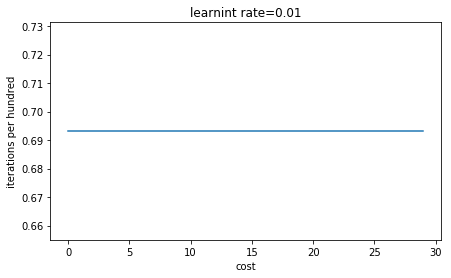

W1 = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
W2 = [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
b2 = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
W3 = [[0. 0. 0. 0. 0.]]
b3 = [[0.]]
W1 = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
W2 = [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
b2 = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]]
W3 = [[0. 0. 0. 0. 0.]]
b3 = [[0.]]


In [42]:
init_parameters_zeros,parameters_zeros,_=L_layer_model(train_x,train_y,[2,10,5,1],initialization='zero',learning_rate=0.01,num_iterations=3000,print_cost=False)

print("W1 = " + str(init_parameters_zeros["W1"]))
print("b1 = " + str(init_parameters_zeros["b1"]))
print("W2 = " + str(init_parameters_zeros["W2"]))
print("b2 = " + str(init_parameters_zeros["b2"]))
print("W3 = " + str(init_parameters_zeros["W3"]))
print("b3 = " + str(init_parameters_zeros["b3"]))

print("W1 = " + str(parameters_zeros["W1"]))
print("b1 = " + str(parameters_zeros["b1"]))
print("W2 = " + str(parameters_zeros["W2"]))
print("b2 = " + str(parameters_zeros["b2"]))
print("W3 = " + str(parameters_zeros["W3"]))
print("b3 = " + str(parameters_zeros["b3"]))


accuracy=50.00%
accuracy=50.00%


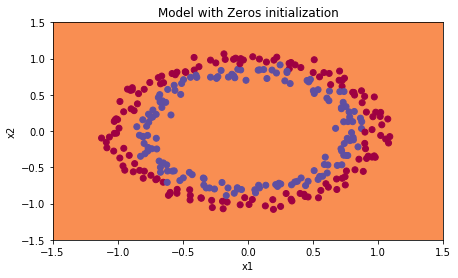

In [43]:
prediction_train=predict(train_x,train_y,parameters_zeros)
prediction_test=predict(test_x,test_y,parameters_zeros)
plt.title("Model with Zeros initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x:predict_dec(x.T,parameters_zeros) ,train_x,np.squeeze(train_y))

#### random初始化
- 放大10倍的初始化方法有点过于暴力，直接导致出现溢出
- 将学习率调到非常小时，模型开始训练，但是训练时间延长后，权重还是趋近于nan

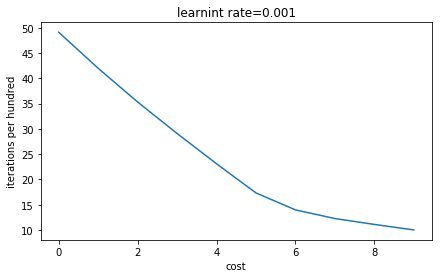

W1 = [[ 17.88628473   4.36509851]
 [  0.96497468 -18.63492703]
 [ -2.77388203  -3.54758979]
 [ -0.82741481  -6.27000677]
 [ -0.43818169  -4.7721803 ]
 [-13.13864753   8.8462238 ]
 [  8.81318042  17.09573064]
 [  0.50033642  -4.04677415]
 [ -5.45359948 -15.46477316]
 [  9.82367434 -11.0106763 ]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-11.85046527  -2.05649899  14.86148355   2.36716267 -10.2378514
   -7.129932     6.25244966  -1.60513363  -7.6883635   -2.30030722]]
b2 = [[0.]]
W1 = [[ 16.66343064   5.00883777]
 [  0.93553454 -18.53170266]
 [ -2.95020435  -4.30379858]
 [ -0.7330454   -6.46694577]
 [ -0.66529652  -4.06404425]
 [-12.6744087    9.04998133]
 [  9.2000784   17.02174589]
 [  0.42815599  -3.93693559]
 [ -5.46291223 -14.97946689]
 [  9.68220588 -10.91348472]]
b1 = [[-1.47313418]
 [-0.21253781]
 [ 3.27298807]
 [ 0.44023074]
 [-1.26039859]
 [-0.37062411]
 [ 0.73296473]
 [-0.22729769]
 [-1.04387465]
 [-0.30668985]]
W2 = [[-10.31439891  -0.62037976  

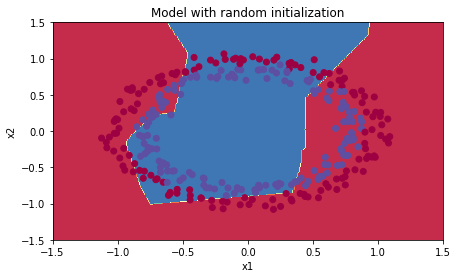

In [56]:
init_parameters_random,parameters_random,_=L_layer_model(train_x,train_y,[2,10,1],initialization='random',learning_rate=0.001,num_iterations=1000,print_cost=False)

print("W1 = " + str(init_parameters_random["W1"]))
print("b1 = " + str(init_parameters_random["b1"]))
print("W2 = " + str(init_parameters_random["W2"]))
print("b2 = " + str(init_parameters_random["b2"]))
# print("W3 = " + str(init_parameters_random["W3"]))
# print("b3 = " + str(init_parameters_random["b3"]))

print("W1 = " + str(parameters_random["W1"]))
print("b1 = " + str(parameters_random["b1"]))
print("W2 = " + str(parameters_random["W2"]))
print("b2 = " + str(parameters_random["b2"]))
# print("W3 = " + str(parameters_random["W3"]))
# print("b3 = " + str(parameters_random["b3"]))


prediction_train=predict(train_x,train_y,parameters_random)
prediction_test=predict(test_x,test_y,parameters_random)
plt.title("Model with random initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x:predict_dec(x.T,parameters_random) ,train_x,np.squeeze(train_y))

#### he 初始化方法

- 出现问题：训练集和预测集误差较大
    - 原因：(训练时间需要延长)

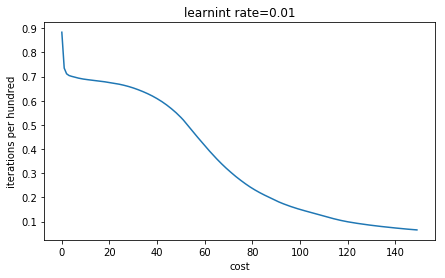

W1 = [[ 1.78862847  0.43650985]
 [ 0.09649747 -1.8634927 ]
 [-0.2773882  -0.35475898]
 [-0.08274148 -0.62700068]
 [-0.04381817 -0.47721803]
 [-1.31386475  0.88462238]
 [ 0.88131804  1.70957306]
 [ 0.05003364 -0.40467741]
 [-0.54535995 -1.54647732]
 [ 0.98236743 -1.10106763]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.52996892 -0.09196943  0.66462575  0.10586273 -0.45785063 -0.31886025
   0.27961805 -0.07178376 -0.34383407 -0.10287287]
 [ 0.33319929  0.88374361 -0.55638887 -0.28014216 -0.35945513 -1.08184688
  -0.41313235 -0.45789116  0.50265822 -0.05899384]
 [-0.72595532  0.28920205 -0.15932913 -0.77955637 -0.26682983 -0.26322741
  -0.39081204  0.01328842 -1.00545144 -0.11974675]
 [ 0.45310941  0.38138279  0.49559652  0.50060672  0.66524951 -0.50011927
   0.3782682  -0.8322151  -0.26961842 -0.85617793]
 [ 0.46874582  0.59646569 -0.08828653  0.79364539 -0.30174732  0.06735791
   0.0683994  -0.47592259  0.19585568  0.86713753]]
b2 = [[0.]
 [0.]
 [0.]
 [0.

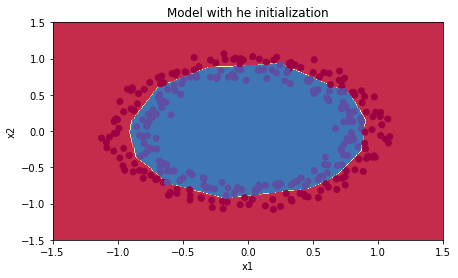

In [58]:
init_parameters_he,parameters_he,_=L_layer_model(train_x,train_y,[2,10,5,1],initialization='he',learning_rate=0.01,num_iterations=15000,print_cost=False)

print("W1 = " + str(init_parameters_he["W1"]))
print("b1 = " + str(init_parameters_he["b1"]))
print("W2 = " + str(init_parameters_he["W2"]))
print("b2 = " + str(init_parameters_he["b2"]))
print("W3 = " + str(init_parameters_he["W3"]))
print("b3 = " + str(init_parameters_he["b3"]))

print("W1 = " + str(parameters_he["W1"]))
print("b1 = " + str(parameters_he["b1"]))
print("W2 = " + str(parameters_he["W2"]))
print("b2 = " + str(parameters_he["b2"]))
print("W3 = " + str(parameters_he["W3"]))
print("b3 = " + str(parameters_he["b3"]))


prediction_train=predict(train_x,train_y,parameters_he)
prediction_test=predict(test_x,test_y,parameters_he)
plt.title("Model with he initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x:predict_dec(x.T,parameters_he) ,train_x,np.squeeze(train_y))